Получены новые признаки (признаки даты, лаги и скользящее среднее по ним, признаки из исходных), так же некоторые числовые признаки были преобразованы. Лучшее качество показала модель catboost. Были удалены силько коррелирующие и признаки с одним значением, удаление остальных (не информативных по catboost) признаков не улучшало качество. Затем на полученных данных обучался catboost, OHE показал результаты хуже встроенной обработки catboost, масштабирование числовых признаков не улучшило качество. Гиперпараметры подбирались с помощью optuna.

In [ ]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor, Pool

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

np.random.seed(0)

warnings.filterwarnings("ignore")

In [ ]:
df2018 = pd.read_excel('Данные 2018 год.xlsx')
df2019 = pd.read_excel('Данные 2019 год.xlsx')
df2020 = pd.read_excel('Данные 2020 год.xlsx')


In [ ]:
df_full = pd.concat([df2018, df2019, df2020], axis=0)

# Создание и преобразание признаков

In [ ]:
df_full.Дата = pd.to_datetime(df_full.Дата)
df_full = df_full.reset_index(drop=True)
df_full['потребление_к_план'] = df_full['Потребление, МВт*ч'] / \
(df_full['План ГЭС, МВт*ч'] + df_full['План АЭС, МВт*ч'] + \
 df_full['План ТЭС, МВт*ч'] + df_full['План СЭС, МВт*ч'] + df_full['План ВЭС, МВт*ч'] + df_full['План ВИЭ, МВт*ч'])

# df_full['экспорт_импорт'] = df_full['Экспорт, МВт*ч'] / (df_full['Импорт, МВт*ч'] + 1)
# df_full['План_ГЭС_0'] = np.where(df_full['План ГЭС, МВт*ч'] == 0, 1, 0)
# df_full['План_АЭС_0'] = np.where(df_full['План АЭС, МВт*ч'] == 0, 1, 0)
# df_full['План_СЭС_0'] = np.where(df_full['План СЭС, МВт*ч'] == 0, 1, 0)
# df_full['План_ВЭС_0'] = np.where(df_full['План ВЭС, МВт*ч'] == 0, 1, 0)

df_full

,Дата,ЦЗ,ЗСП,Час,"План ГЭС, МВт*ч","План АЭС, МВт*ч","План ТЭС, МВт*ч","ТЭС мин, МВт*ч","ТЭС макс, МВт*ч","Потребление, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч","План СЭС, МВт*ч","План ВЭС, МВт*ч","План ВИЭ, МВт*ч","Ценопринимающее предложение, МВт*ч","Ценопринимание сверх минимальной мощности, МВт*ч","Цена продажи, руб./МВт*ч",потребление_к_план
0,2018-01-01,Европа,FZUROE07,8,145.600,616.0,15310.118,12985.703,18417.555,16133.167,1724.097,2122.273,8.3,0.0,0,82858.55,6103.482,776.250,1.003305
1,2018-01-01,Европа,FZURTU08,8,0.000,0.0,11906.500,8014.692,12166.200,9971.934,1658.871,29.774,0.0,0.0,0,82858.55,6103.482,685.400,0.837520
2,2018-01-01,Европа,FZVLBS15,8,120.000,4073.0,576.000,576.000,640.000,1375.474,3260.660,1.122,0.6,0.0,0,82858.55,6103.482,781.870,0.288384
3,2018-01-01,Европа,FZVLOE13,8,500.000,49.5,3857.360,3777.730,4461.390,5812.795,1369.469,2873.540,0.0,3.5,0,82858.55,6103.482,823.300,1.317987
4,2018-01-01,Европа,FZYUAS18,8,0.000,0.0,431.500,326.297,531.500,532.284,30.329,154.762,2.0,0.0,0,82858.55,6103.482,890.730,1.227875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348115,2020-08-24,Европа,FZYUKU20,23,6.200,4127.0,3009.946,2776.946,4084.745,5558.013,1812.187,364.917,0.0,105.3,0,69677.56,2497.429,1028.609,0.766787
348116,2020-08-24,Европа,FZYUOE16,23,322.788,0.0,654.597,554.694,1171.700,1652.503,214.470,949.979,0.0,0.0,0,69677.56,2497.429,1033.096,1.690739
348117,2020-08-24,Европа,FZYUVG17,23,1120.000,0.0,297.000,297.000,393.000,1411.464,848.521,899.929,0.0,0.0,0,69677.56,2497.429,1031.762,0.996093
348118,2020-08-24,Европа,FZZMSK26,23,0.000,0.0,4777.119,4137.211,6551.619,9348.429,97.190,4778.966,0.0,0.0,0,69677.56,2497.429,1183.862,1.956918


In [ ]:
def q15(x):
    return x.quantile(0.15)

key = 'ЗСП'
value = 'Цена продажи, руб./МВт*ч'
len_month = 31*24

window = 24 * 7
min_periods = 24 * 7
alpha=0.09
df_full['lag_1month'] = df_full.groupby(key)[value].transform(lambda x: x.shift(len_month))

df_full['lag_2month'] = df_full.groupby(key)[value].transform(lambda x: x.shift(len_month*2))
# df_full['lag_3month'] = df_full.groupby(key)[value].transform(lambda x: x.shift(len_month*3))
# df_full['lag_4month'] = df_full.groupby(key)[value].transform(lambda x: x.shift(len_month*4))
df_full['lag_6month'] = df_full.groupby(key)[value].transform(lambda x: x.shift(len_month*6))
df_full['lag_9month'] = df_full.groupby(key)[value].transform(lambda x: x.shift(len_month*9))

df_full['exp_lag'] = df_full.groupby(key)[value].transform(lambda x: x.shift(len_month*2).ewm(alpha=alpha).mean())

df_full['window_mean'] = df_full.groupby(key)['lag_1month'].transform(lambda x: x.rolling(window=window, min_periods=min_periods).mean())
df_full['window_max'] = df_full.groupby(key)['lag_1month'].transform(lambda x: x.rolling(window=window, min_periods=min_periods).max())
# df_full['window_quantile_15'] = df_full.groupby(key)['lag_1month'].transform(lambda x: x.rolling(window=window, min_periods=min_periods).apply(q15))
df_full['window_std'] = df_full.groupby(key)['lag_1month'].transform(lambda x: x.rolling(window=window, min_periods=min_periods).std())
# df_full['window_var'] = df_full.groupby(key)['lag_1month'].transform(lambda x: x.rolling(window=window, min_periods=min_periods).var())


In [ ]:
test = df_full[df_full["Дата"] > "2020-07-25 00:00:00.000"]
valid = df_full[(df_full["Дата"] > "2020-05-23 00:00:00.000") & (df_full["Дата"] <= "2020-07-25 00:00:00.000")]
train = df_full[df_full["Дата"] < "2020-05-24 00:00:00.000"]

In [ ]:
def extract_from_date(data,time_column):

    data["year"]=data[time_column].dt.year
    data["quarter"]=data[time_column].dt.quarter
    data["month"]=data[time_column].dt.month
    data["dayofmonth"]=data[time_column].dt.day
    data["day_name"]=data[time_column].dt.day_name()
    data['is_weekend'] = np.where(data['day_name'].isin(['Sunday', 'Saturday']), 1,0)
    data["is_year_start"]=data[time_column].dt.is_year_start
    data['hour_sin'] = np.sin(2 * np.pi * data['Час']/24.0)
    data['hour_cos'] = np.cos(2 * np.pi * data['Час']/24.0)

    return data

train=extract_from_date(train,"Дата")
valid=extract_from_date(valid,"Дата")
test = extract_from_date(test,"Дата")

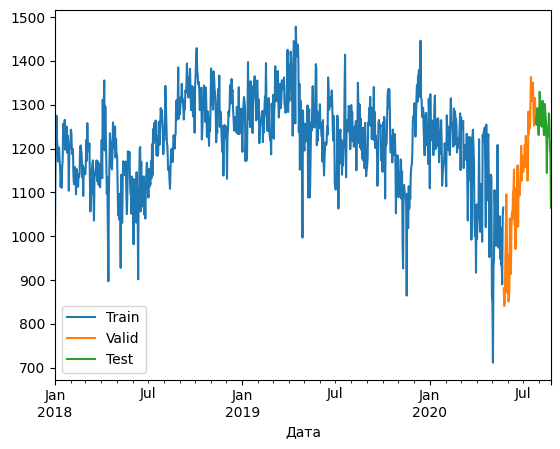

In [ ]:
train.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
valid.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
test.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
plt.legend(['Train', 'Valid', 'Test']);

In [ ]:
train #в новых признаках lag есть пропуски, но их заполнение только немного ухудшает качество, чем встроенная в catboost

,Дата,ЦЗ,ЗСП,Час,"План ГЭС, МВт*ч","План АЭС, МВт*ч","План ТЭС, МВт*ч","ТЭС мин, МВт*ч","ТЭС макс, МВт*ч","Потребление, МВт*ч",...,window_std,year,quarter,month,dayofmonth,day_name,is_weekend,is_year_start,hour_sin,hour_cos
0,2018-01-01,Европа,FZUROE07,8,145.60,616.0,15310.118,12985.703,18417.555,16133.167,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.500000
1,2018-01-01,Европа,FZURTU08,8,0.00,0.0,11906.500,8014.692,12166.200,9971.934,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.500000
2,2018-01-01,Европа,FZVLBS15,8,120.00,4073.0,576.000,576.000,640.000,1375.474,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.500000
3,2018-01-01,Европа,FZVLOE13,8,500.00,49.5,3857.360,3777.730,4461.390,5812.795,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.500000
4,2018-01-01,Европа,FZYUAS18,8,0.00,0.0,431.500,326.297,531.500,532.284,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314635,2020-05-23,Европа,FZYUKU20,23,78.70,3970.0,1904.945,1666.945,2663.055,4654.251,...,309.153949,2020,2,5,23,Saturday,1,False,-0.258819,0.965926
314636,2020-05-23,Европа,FZYUOE16,23,395.02,0.0,249.400,214.900,444.400,1619.514,...,330.339674,2020,2,5,23,Saturday,1,False,-0.258819,0.965926
314637,2020-05-23,Европа,FZYUVG17,23,2274.40,0.0,268.000,267.000,349.000,1436.651,...,293.774346,2020,2,5,23,Saturday,1,False,-0.258819,0.965926
314638,2020-05-23,Европа,FZZMSK26,23,0.00,0.0,5212.675,4142.989,6338.189,10361.555,...,299.158164,2020,2,5,23,Saturday,1,False,-0.258819,0.965926


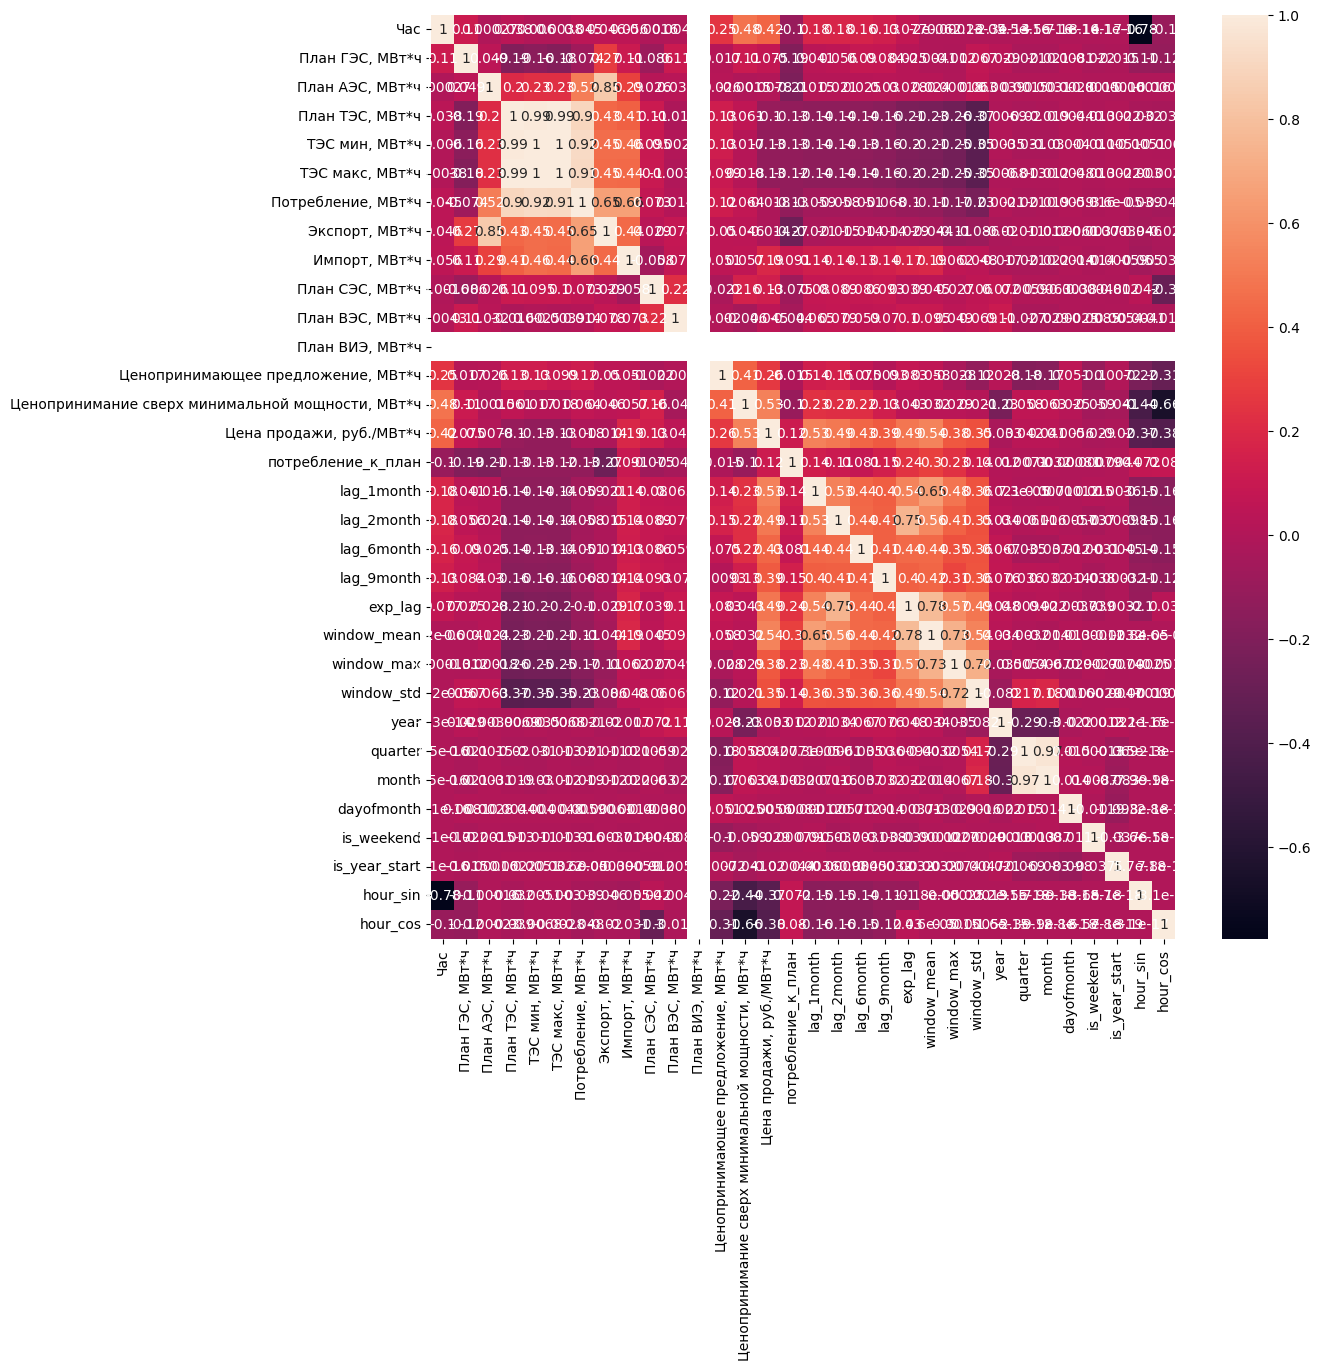

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(train.corr(), annot=True);

In [ ]:
drop_col = [ 'Дата','ЦЗ', 'Цена продажи, руб./МВт*ч', 'План ВИЭ, МВт*ч', 'ТЭС мин, МВт*ч', 'ТЭС макс, МВт*ч',

            ]   #удаление других фичей, даже с низкой важность по catboost, не дало улучшений


In [ ]:
y_train = train['Цена продажи, руб./МВт*ч']
X_train = train.drop(columns=drop_col)

y_valid = valid['Цена продажи, руб./МВт*ч']
X_valid = valid.drop(columns=drop_col)


y_test = test['Цена продажи, руб./МВт*ч']
X_test = test.drop(columns=drop_col)

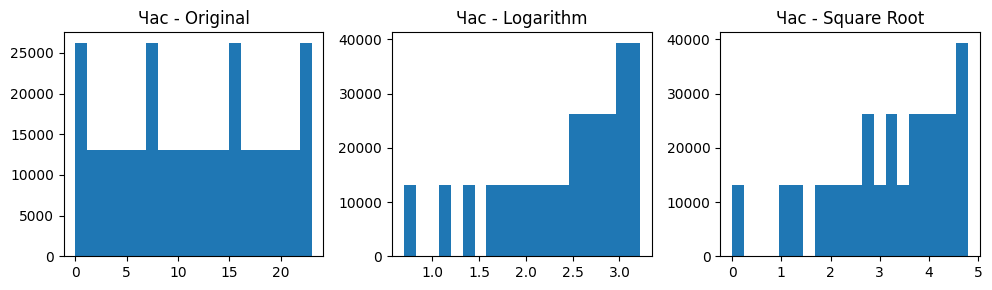

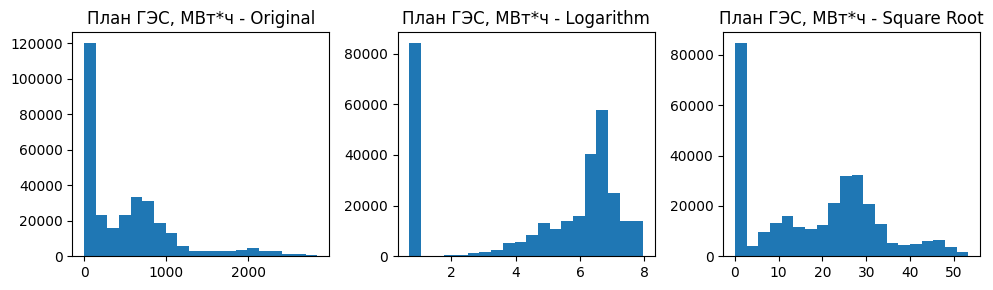

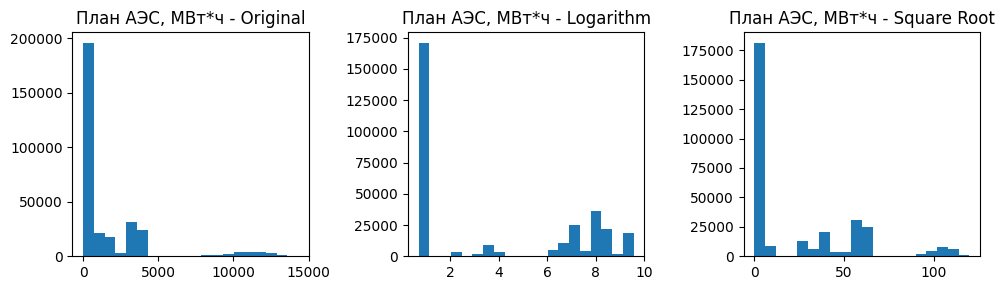

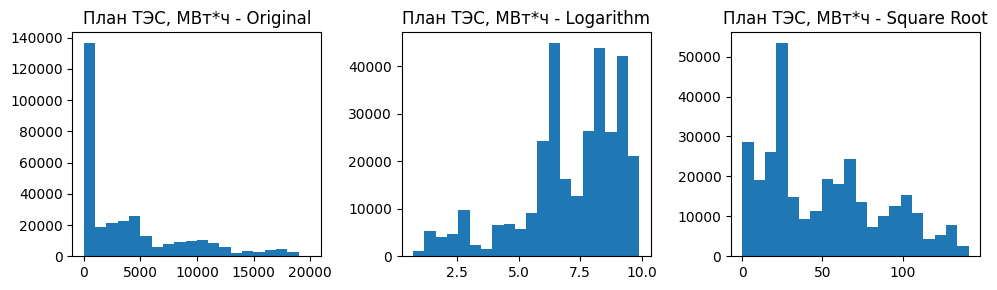

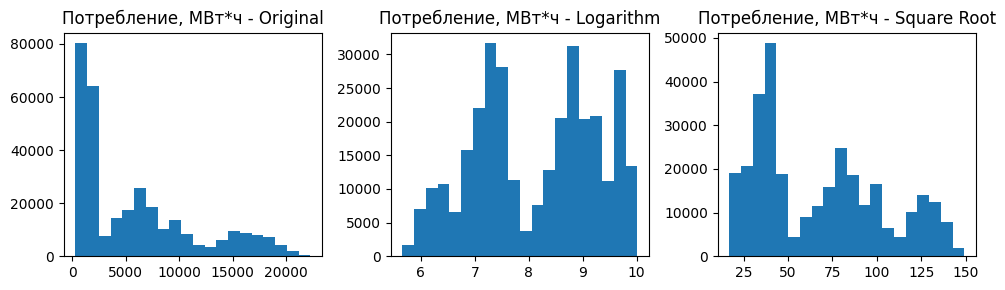

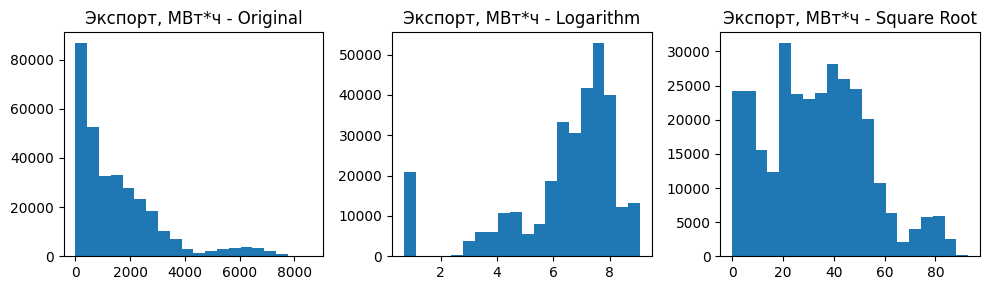

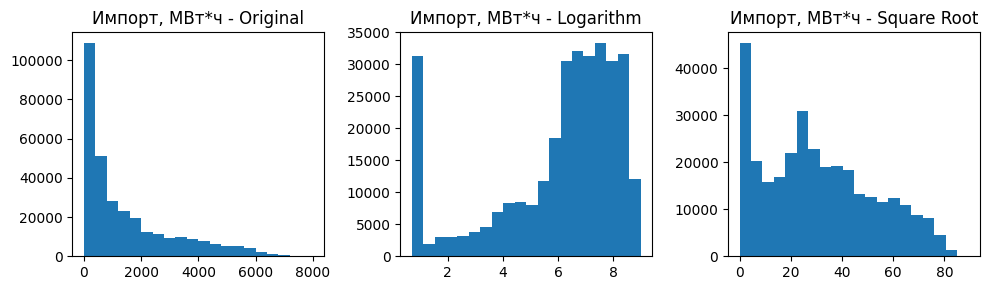

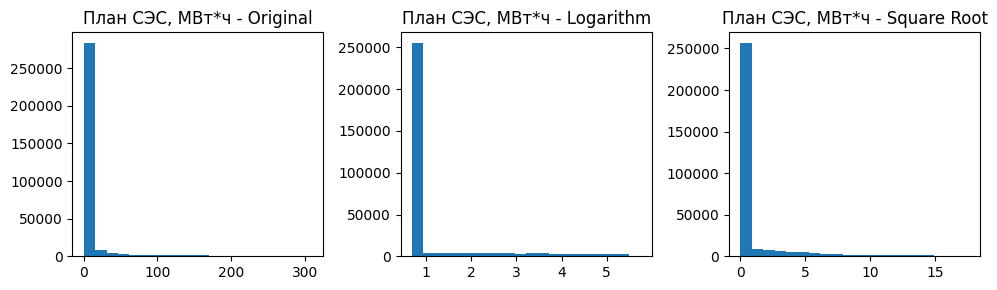

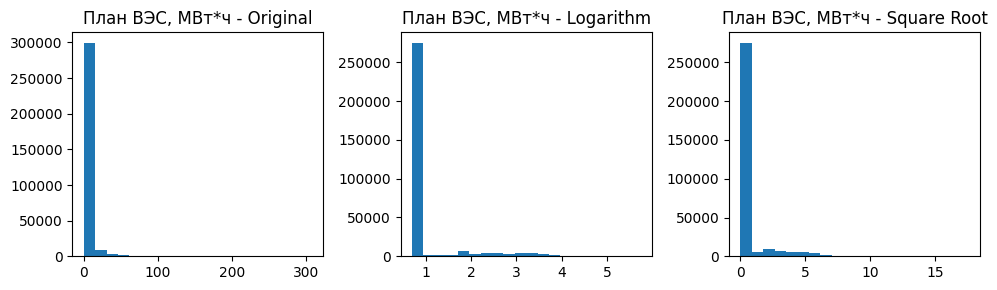

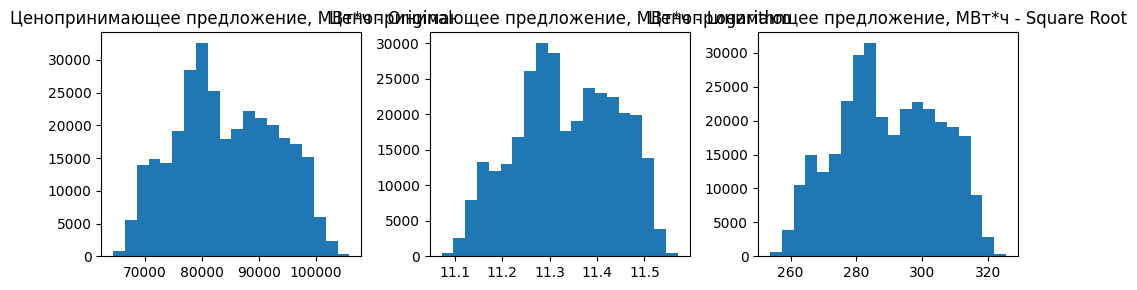

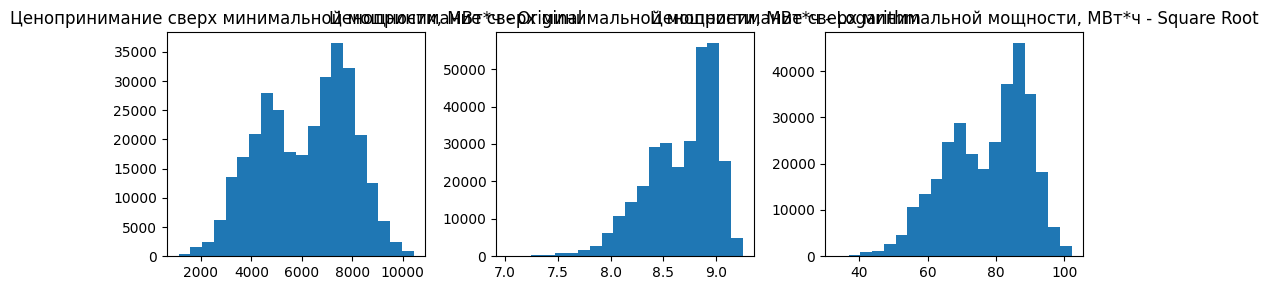

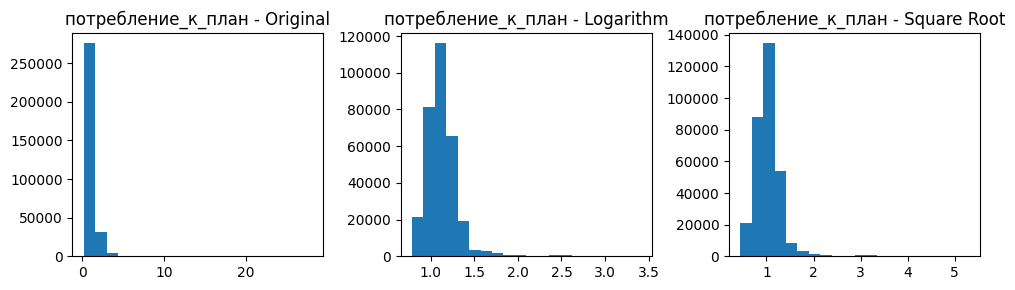

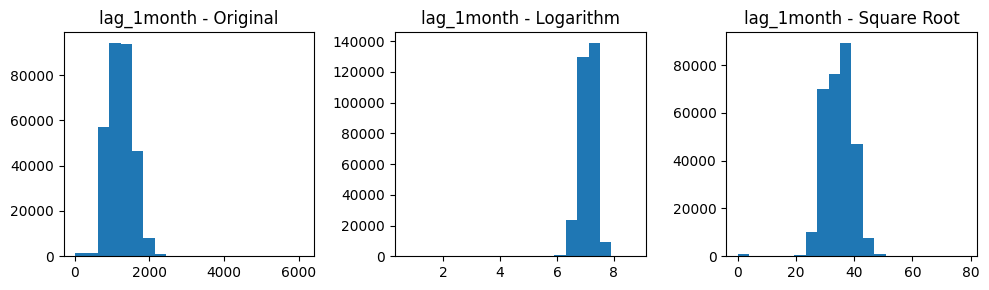

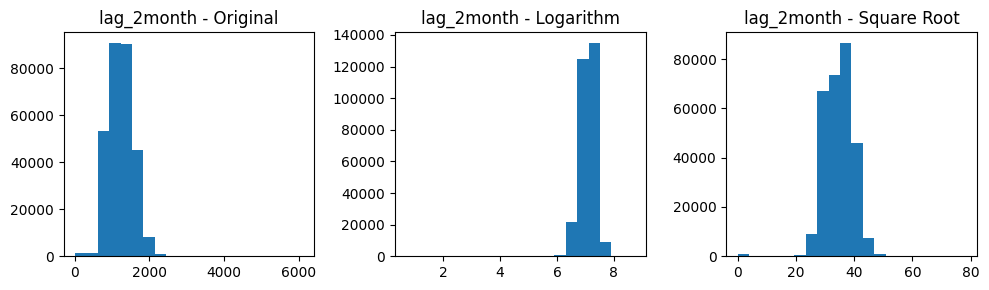

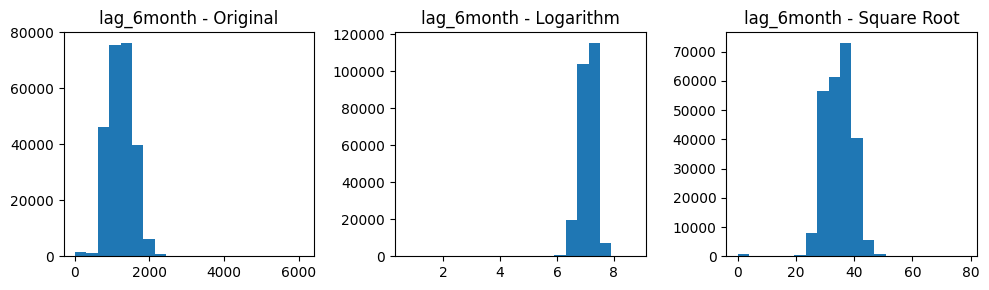

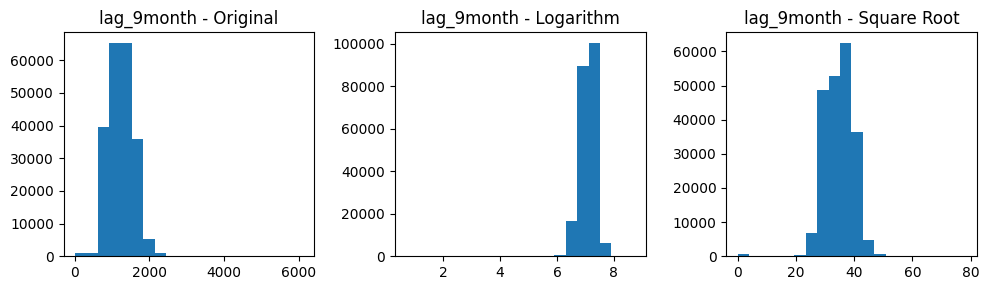

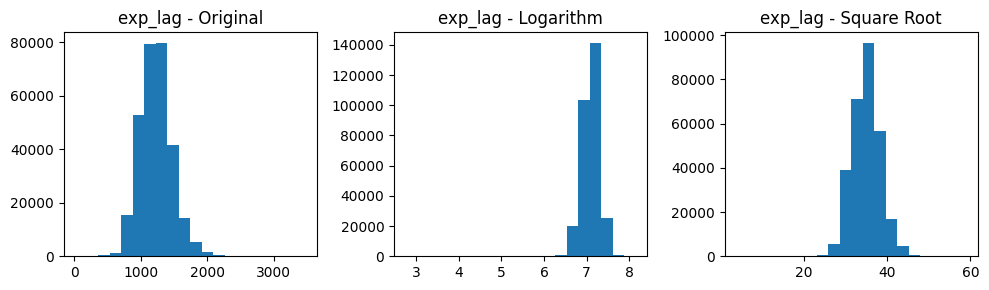

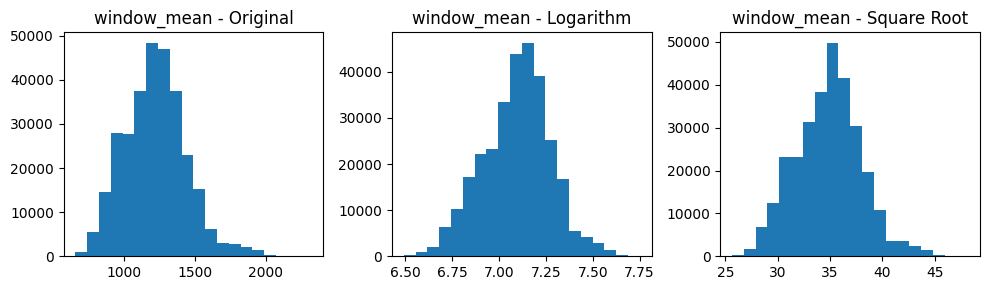

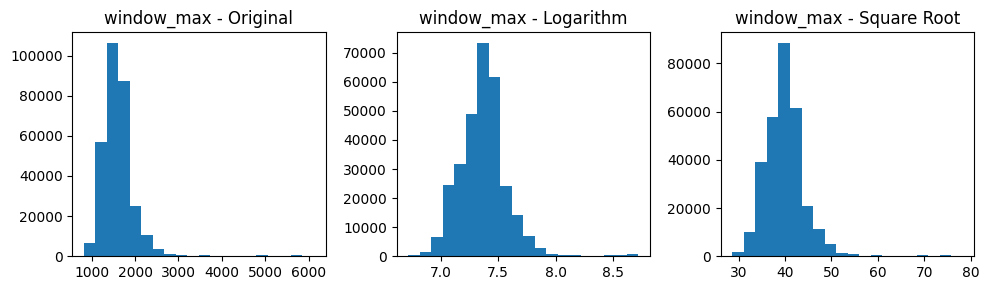

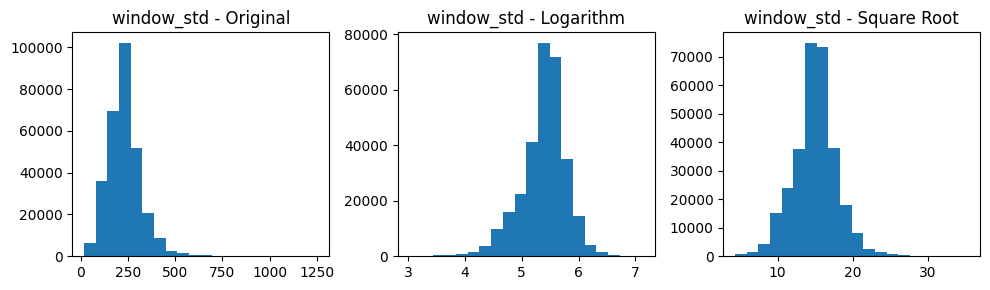

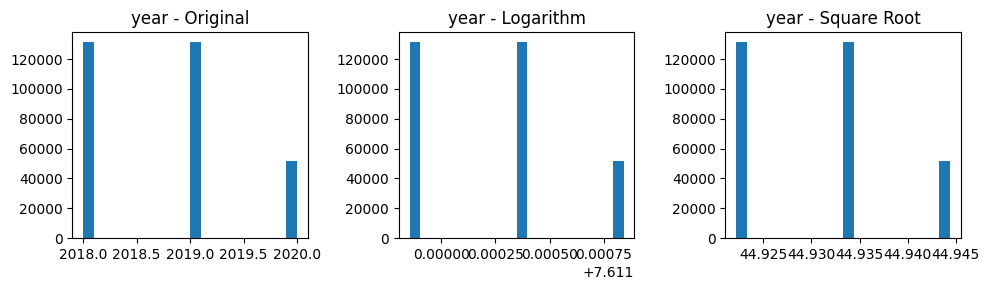

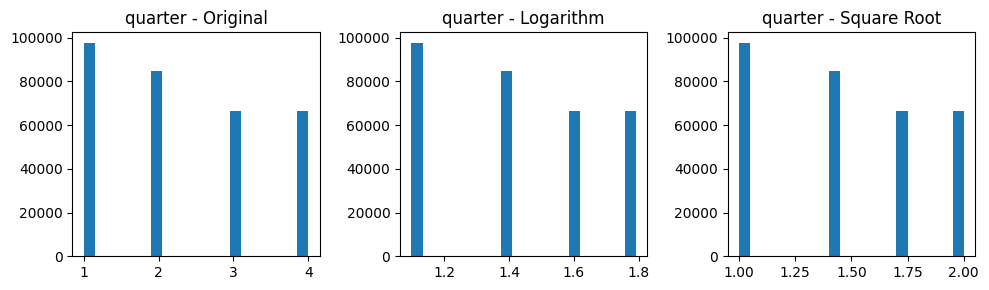

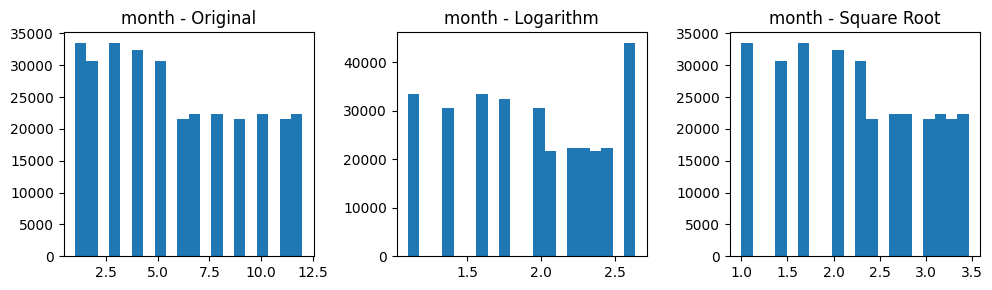

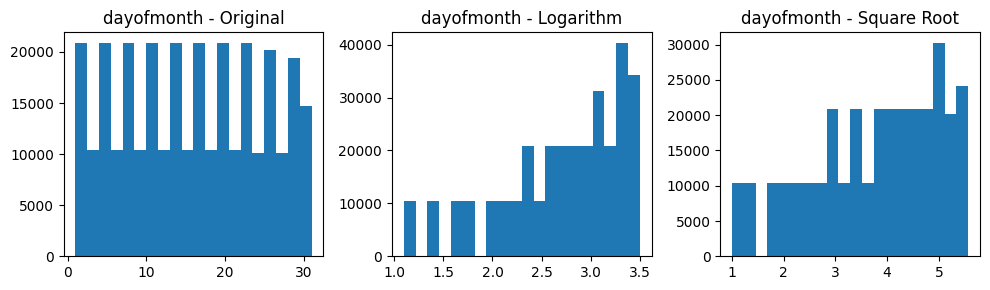

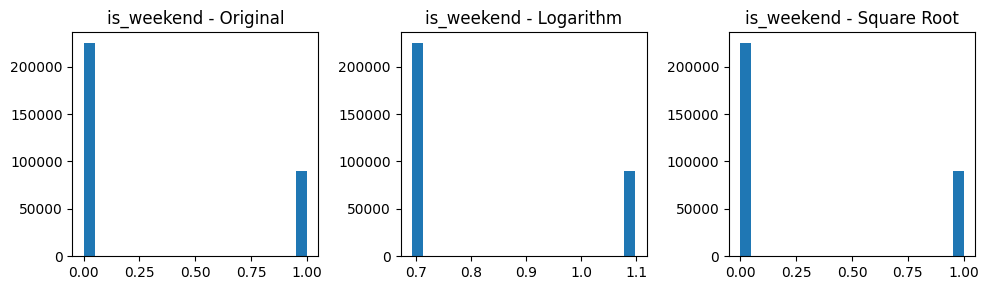

In [ ]:
# Распределение числовых переменных
for feature in X_train.select_dtypes(include=['float64', 'int64']).columns:
    if feature not in ['hour_cos', 'hour_sin']:
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 3, 1)
        plt.hist(X_train[feature], bins=20)
        plt.title(f'{feature} - Original')

        plt.subplot(1, 3, 2)
        plt.hist(np.log1p(X_train[feature]+1), bins=20)
        plt.title(f'{feature} - Logarithm')

        plt.subplot(1, 3, 3)
        plt.hist(np.sqrt(X_train[feature]), bins=20)
        plt.title(f'{feature} - Square Root')



        plt.tight_layout()
        plt.show()


In [ ]:
# Преобразование некоторых числовых переменных
columns_to_sqrt = ['План ГЭС, МВт*ч',
 'План АЭС, МВт*ч',
 'План ТЭС, МВт*ч',
 'Потребление, МВт*ч',
 'Экспорт, МВт*ч',
 'Импорт, МВт*ч',
 'План СЭС, МВт*ч',
 'План ВЭС, МВт*ч',
"потребление_к_план"
]


for col in columns_to_sqrt:
    X_train[col] = np.sqrt(X_train[col])
    X_valid[col] = np.sqrt(X_valid[col])
    X_test[col] = np.sqrt(X_test[col])

In [ ]:
X_train.head()

,ЗСП,Час,"План ГЭС, МВт*ч","План АЭС, МВт*ч","План ТЭС, МВт*ч","Потребление, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч","План СЭС, МВт*ч","План ВЭС, МВт*ч",...,window_std,year,quarter,month,dayofmonth,day_name,is_weekend,is_year_start,hour_sin,hour_cos
0,FZUROE07,8,12.066483,24.819347,123.734062,127.016404,41.522247,46.068134,2.880972,0.000000,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.5
1,FZURTU08,8,0.000000,0.000000,109.116910,99.859571,40.729240,5.456556,0.000000,0.000000,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.5
2,FZVLBS15,8,10.954451,63.820060,24.000000,37.087383,57.102189,1.059245,0.774597,0.000000,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.5
3,FZVLOE13,8,22.360680,7.035624,62.107648,76.241688,37.006337,53.605410,0.000000,1.870829,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.5
4,FZYUAS18,8,0.000000,0.000000,20.772578,23.071281,5.507177,12.440338,1.414214,0.000000,...,NaN,2018,1,1,1,Monday,0,True,0.866025,-0.5


In [ ]:
# for i in X_train.columns:
#     if X_train[i].nunique() < 100:
#         print(i, X_train[i].nunique() )

cat_features = ['Час','ЗСП',
#                 'quarter',  лучше работал как числовой, как и год
                'day_name', 'month', 'is_weekend', 'is_year_start']
num_features = [i for i in X_train.columns if i not in cat_features]
num_features

['План ГЭС, МВт*ч',
 'План АЭС, МВт*ч',
 'План ТЭС, МВт*ч',
 'Потребление, МВт*ч',
 'Экспорт, МВт*ч',
 'Импорт, МВт*ч',
 'План СЭС, МВт*ч',
 'План ВЭС, МВт*ч',
 'Ценопринимающее предложение, МВт*ч',
 'Ценопринимание сверх минимальной мощности, МВт*ч',
 'потребление_к_план',
 'lag_1month',
 'lag_2month',
 'lag_6month',
 'lag_9month',
 'exp_lag',
 'window_mean',
 'window_max',
 'window_std',
 'year',
 'quarter',
 'dayofmonth',
 'hour_sin',
 'hour_cos']

# Обучение модели

In [ ]:
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_valid,
                 label=y_valid,
                 cat_features=cat_features)

test_dataset = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features)


params={'learning_rate': 0.18510116462294962, 'depth': 6, 'min_data_in_leaf': 17, 'l2_leaf_reg': 11.01, 'random_strength': 0.7000219219311835}
# params =  {'learning_rate': 0.11031652269152678, 'depth': 6, 'min_data_in_leaf': 19, 'l2_leaf_reg': 15.485244855402454, 'random_strength': 0.6856778884445798}
# параметры подбирались с помощью optuna (код в конце)

model = CatBoostRegressor(**params, verbose=200, random_state=42, task_type='GPU')

model.fit(train_dataset,eval_set=eval_dataset, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 295.9538340	test: 336.3790924	best: 336.3790924 (0)	total: 32ms	remaining: 32s
200:	learn: 119.4046764	test: 185.6799013	best: 185.6359753 (199)	total: 9.33s	remaining: 37.1s
400:	learn: 107.5815646	test: 182.5936130	best: 182.2332478 (386)	total: 14.2s	remaining: 21.2s
600:	learn: 101.0875014	test: 181.9961354	best: 181.8771180 (567)	total: 20.8s	remaining: 13.8s
800:	learn: 96.4548340	test: 181.5941091	best: 181.4568907 (754)	total: 25.7s	remaining: 6.38s
999:	learn: 92.6139345	test: 180.2127373	best: 180.0254577 (971)	total: 32.2s	remaining: 0us
bestTest = 180.0254577
bestIteration = 971
Shrink model to first 972 iterations.


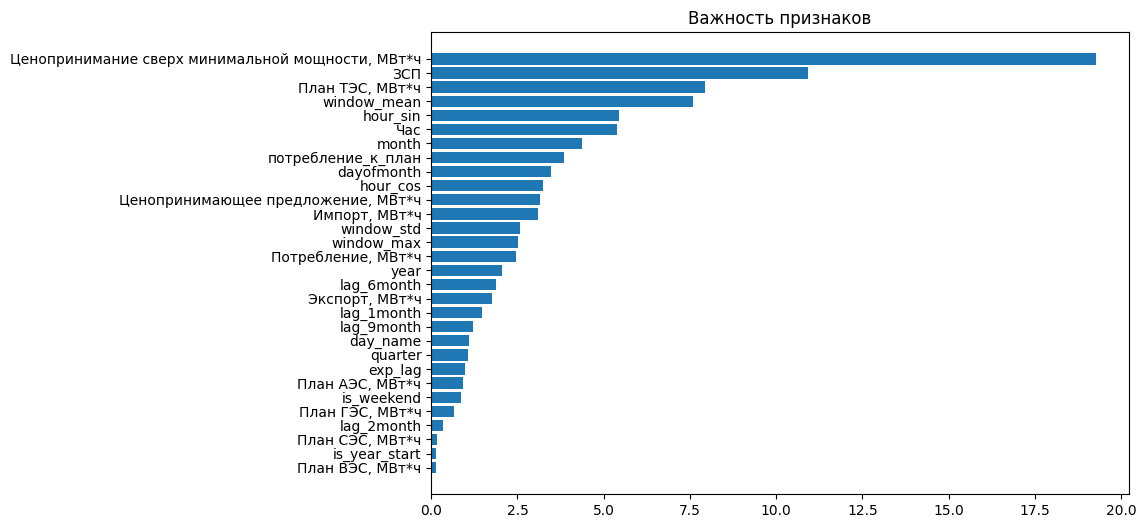

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(9, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Важность признаков');

In [ ]:
valid_predict = model.predict(eval_dataset)
test_predict = model.predict(test_dataset)


In [ ]:
valid_1 = valid.copy()
test_1 = test.copy()

valid_1['prediction'] = valid_predict
test_1['prediction'] = test_predict

val_mean = valid_1.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().values
val_mean_pred = valid_1.groupby("Дата")['prediction'].mean().values

test_mean = test_1.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().values
test_mean_pred = test_1.groupby("Дата")['prediction'].mean().values

In [ ]:
# print(
rmse_val = mean_squared_error(y_valid,valid_predict , squared=False)
rmse_test = mean_squared_error(y_test,test_predict , squared=False)
mae_val = mean_absolute_error(y_valid,valid_predict)
mae_test = mean_absolute_error(y_test,test_predict)


print(f'Валидация: rmse = {rmse_val.round(3)}, mae = {mae_val.round(3)}')
print(f'Тест: rmse = {rmse_test.round(3)}, mae = {mae_test.round(3)}')


Валидация: rmse = 180.026, mae = 123.977
Тест: rmse = 156.158, mae = 117.758


In [ ]:
rmse_val_day = mean_squared_error(val_mean,val_mean_pred , squared=False)
rmse_test_day = mean_squared_error(test_mean,test_mean_pred , squared=False)
mae_val_day = mean_absolute_error(val_mean,val_mean_pred)
mae_test_day = mean_absolute_error(test_mean,test_mean_pred)
mape_val_day = mean_absolute_percentage_error(val_mean,val_mean_pred)
mape_test_day = mean_absolute_percentage_error(test_mean,test_mean_pred)

print('Метрики для цен, усредненных по дням:')
print(f'Валидация: rmse = {rmse_val_day.round(3)}, mae = {mae_val_day.round(3)}, mape = {mape_val_day.round(3)}')
print(f'Тест: rmse = {rmse_test_day.round(3)}, mae = {mae_test_day.round(3)}, mape = {mape_test_day.round(3)}')


Метрики для цен, усредненных по дням:
Валидация: rmse = 90.407, mae = 74.723, mape = 0.07
Тест: rmse = 99.436, mae = 86.394, mape = 0.068


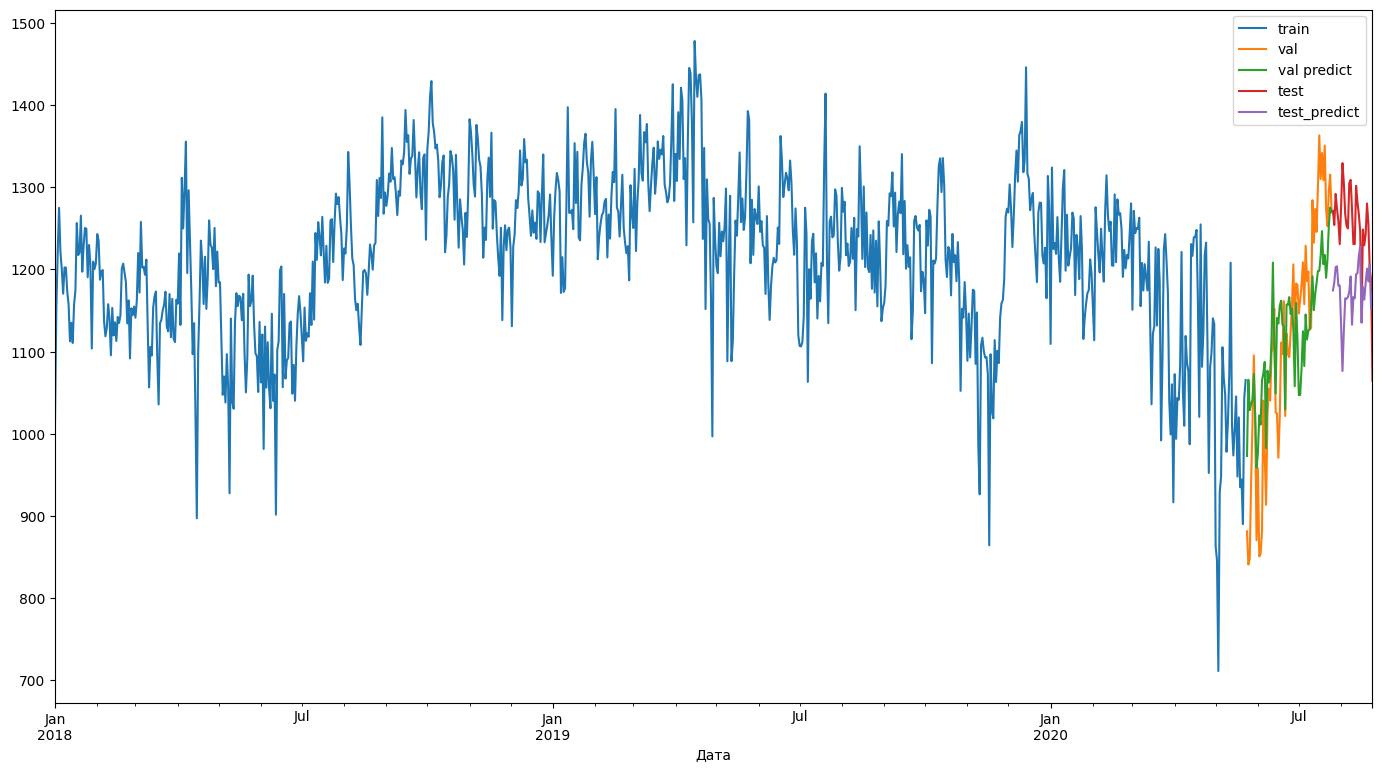

In [ ]:
plt.figure(figsize=(17,9))
train.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
valid_1.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
valid_1.groupby("Дата")['prediction'].mean().plot()
test_1.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
test_1.groupby("Дата")['prediction'].mean().plot()
plt.legend(['train', 'val', 'val predict', 'test', 'test_predict']);

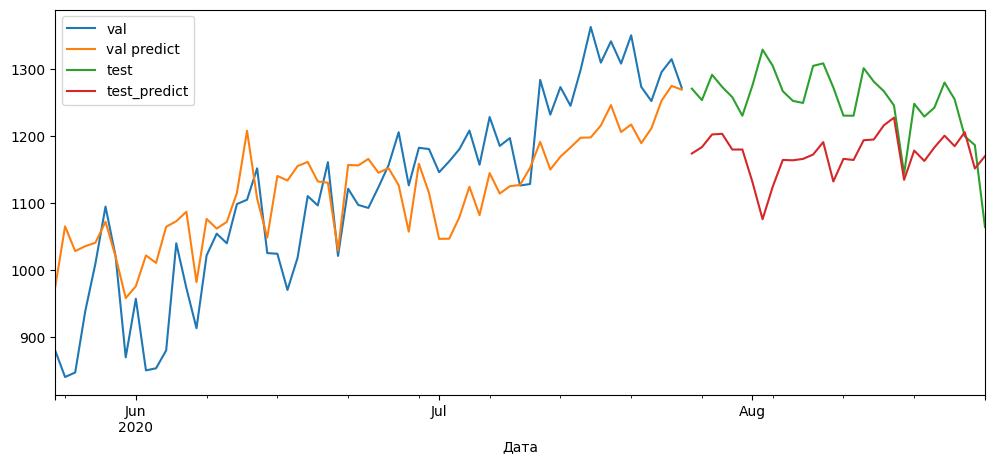

In [ ]:
plt.figure(figsize=(12,5))
valid_1.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
valid_1.groupby("Дата")['prediction'].mean().plot()
test_1.groupby("Дата")['Цена продажи, руб./МВт*ч'].mean().plot()
test_1.groupby("Дата")['prediction'].mean().plot()
plt.legend(['train', 'val', 'val predict', 'test', 'test_predict'])
plt.legend([ 'val', 'val predict', 'test', 'test_predict']);

In [ ]:

def objective(trial):
    params = {
        "iterations": 1400,
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.26, log=True),
        "depth": trial.suggest_int("depth", 3, 8),
        # "subsample": trial.suggest_float("subsample", 0.25, 1.0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 20.0),

        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
        'random_strength': trial.suggest_float('random_strength', 0.51, 1),



    }

    model = CatBoostRegressor(**params, verbose=400, random_state=42,  task_type='GPU')
    model.fit(train_dataset, eval_set=eval_dataset)
    predictions = model.predict(eval_dataset)

    rmse = mean_squared_error(y_valid, predictions, squared=False)

    return rmse


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)


In [ ]:
print(study.best)